In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Input,UpSampling2D,ReLU
from tensorflow.keras.optimizers import RMSprop,Adam
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.datasets
from sklearn.model_selection import train_test_split

In [2]:
(X_train_loaded, y_train), (X_test_loaded, y_test) = tensorflow.keras.datasets.mnist.load_data()

#normalization
X_train_loaded=X_train_loaded.astype("float32")/255.0
X_test_loaded=X_test_loaded.astype("float32")/255.0

#reshape to match input shape
X_train=X_train_loaded.reshape(60000,28,28,1)
X_test=X_test_loaded.reshape(10000,28,28,1)

#train validation split
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1)

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
#encoder definition

enc_in=Input(shape=(28,28,1))

enc_conv_l1=Conv2D(16,kernel_size=3,padding="same")(enc_in)
enc_act_l1=ReLU()(enc_conv_l1)

enc_conv_l2=Conv2D(32,kernel_size=5,padding="same")(enc_act_l1)
enc_act_l2=ReLU()(enc_conv_l2)

enc_mpool_l1=MaxPooling2D()(enc_act_l2)

enc_conv_l3=Conv2D(32,kernel_size=5,padding="same")(enc_mpool_l1)
enc_act_l3=ReLU()(enc_conv_l3)

enc_conv_l4=Conv2D(16,kernel_size=5,padding="same")(enc_act_l3)
enc_act_l4=ReLU()(enc_conv_l4)

enc_mpool_l2=MaxPooling2D()(enc_act_l4)

enc_conv_l5=Conv2D(1,kernel_size=5,padding="same")(enc_mpool_l2)
enc_act_l5=ReLU()(enc_conv_l5)

encoder=Model(enc_in,enc_act_l5)
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
re_lu (ReLU)                 (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        12832     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        25632 

In [4]:
#decoder definition

dec_in=Input(shape=(7,7,1))

dec_conv_l1=Conv2D(16,kernel_size=3,padding='same')(dec_in)
dec_act_l1=ReLU()(dec_conv_l1)

dec_conv_l2=Conv2D(32,kernel_size=3,padding='same')(dec_act_l1)
dec_act_l2=ReLU()(dec_conv_l2)

dec_usamp_l1=UpSampling2D()(dec_act_l2)

dec_conv_l3=Conv2D(32,kernel_size=3,padding='same')(dec_usamp_l1)
dec_act_l3=ReLU()(dec_conv_l3)

dec_conv_l4=Conv2D(16,kernel_size=3,padding='same')(dec_act_l3)
dec_act_l4=ReLU()(dec_conv_l4)

dec_usamp_l2=UpSampling2D()(dec_act_l4)

dec_conv_l5=Conv2D(8,kernel_size=3,padding='same')(dec_usamp_l2)
dec_act_l5=ReLU()(dec_conv_l5)

dec_conv_l6=Conv2D(1,kernel_size=3,padding='same')(dec_act_l5)
dec_act_l6=ReLU()(dec_conv_l6)

decoder=Model(dec_in,dec_act_l6)
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7, 7, 1)]         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 16)          160       
_________________________________________________________________
re_lu_5 (ReLU)               (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
re_lu_6 (ReLU)               (None, 7, 7, 32)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        9248

In [5]:
#combined encoder decoder model for training
enc_dec_input=Input(shape=(28,28,1))
enc_dec_encout=encoder(enc_dec_input)
enc_dec_output=decoder(enc_dec_encout)

enc_dec_model=Model(enc_dec_input,enc_dec_output)
enc_dec_model.compile(loss="mse",optimizer=Adam())
enc_dec_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model (Model)                (None, 7, 7, 1)           51841     
_________________________________________________________________
model_1 (Model)              (None, 28, 28, 1)         19905     
Total params: 71,746
Trainable params: 71,746
Non-trainable params: 0
_________________________________________________________________


In [6]:
#first train only decoder, then only encoder, and finally both together

encoder.trainable=False
enc_dec_model.fit(X_train,X_train,epochs=7,validation_data=(X_val,X_val),batch_size=512)
encoder.trainable=True

decoder.trainable=False
enc_dec_model.fit(X_train,X_train,epochs=8,validation_data=(X_val,X_val),batch_size=512)
decoder.trainable=True

enc_dec_model.fit(X_train,X_train,epochs=15,validation_data=(X_val,X_val),batch_size=512)

Epoch 1/7
106/106 [==============================] - 6s 54ms/step - loss: 0.0397 - val_loss: 0.0151
Epoch 2/7
106/106 [==============================] - 5s 48ms/step - loss: 0.0116 - val_loss: 0.0091
Epoch 3/7
106/106 [==============================] - 5s 47ms/step - loss: 0.0088 - val_loss: 0.0079
Epoch 4/7
106/106 [==============================] - 5s 48ms/step - loss: 0.0072 - val_loss: 0.0068
Epoch 5/7
106/106 [==============================] - 5s 48ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 6/7
106/106 [==============================] - 5s 48ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 7/7
106/106 [==============================] - 5s 48ms/step - loss: 0.0058 - val_loss: 0.0055
Epoch 1/8
106/106 [==============================] - 5s 48ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 2/8
106/106 [==============================] - 5s 47ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 3/8
106/106 [==============================] - 5s 48ms/step - loss: 0.0050 - val_loss: 0.0048


In [0]:
encoded=encoder.predict(X_test)
decoded=decoder.predict(encoded)

In [0]:
%matplotlib inline

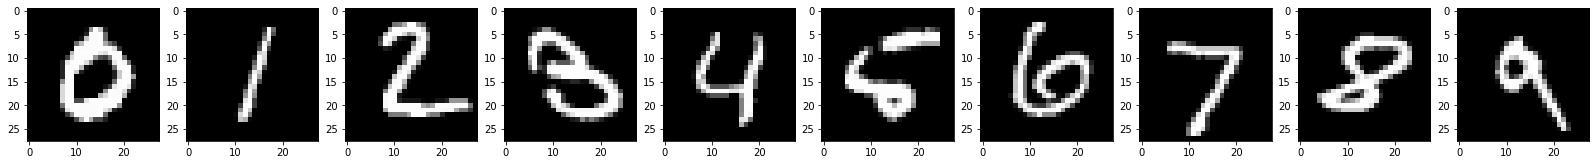

In [9]:
#plot original images from 1 to 10

fig=plt.figure(figsize=(28,28))

indices=list()

for i in range(10):
    j=0;
    while(y_test[j]!=i):
        j+=1

    indices.append(j)
    fig.add_subplot(1,10,i+1)
    plt.imshow(X_test[j].reshape(28,28),cmap='gray')


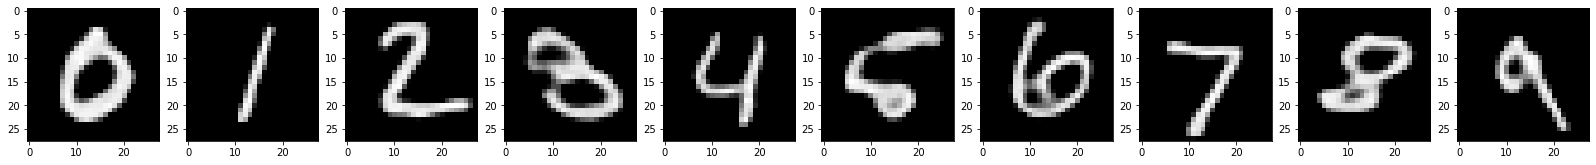

In [10]:
#plot generated images from 1 to 10

fig2=plt.figure(figsize=(28,28))

for i in range(10):
    fig2.add_subplot(1,10,i+1)
    plt.imshow(decoded[indices[i]].reshape(28,28),cmap='gray')